In [ ]:
pip install -U ckiptagger[tf,gdown]

In [12]:
from ckiptagger import data_utils, construct_dictionary, WS, POS

In [13]:
data_utils.download_data_url("./")

In [ ]:
# 因為本機版本不合適，故在colab上做斷詞，並將斷詞結果存入data\dataset1_token.json
ws = WS("./data")
poss = POS("./data")

In [ ]:
# 取得資料集的遊戲簡介
from google.colab import drive
import json

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/gameContent.json'
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

sentence = []
for entry in data:
  description = entry['description']
  cleaned_description = description.replace('\n', '').replace(r'\s+', '').replace('\r', '')
  sentence.append(entry['description'])
print(len(sentence))

In [ ]:
# ckip斷詞+判斷詞性
word_sentence = ws(sentence)    # [[token1, token2...], [token51, token52]...]
pos_sentence = poss(word_sentence)  # [[pos1, pos2...], [pos51, pos52]...]

# 刪除stop word
exclude_pos = ['Dfa', 'DE', 'WHITESPACE', 'PARENTHESISCATEGORY', 'EXCLAMATIONCATEGORY', 'Caa', 'COLONCATEGORY', 'PERIODCATEGORY', 
               'PAUSECATEGORY', 'Cbb', 'P', 'Cbab', 'Dk', 'Neqa', 'SEMICOLONCATEGORY','COMMACATEGORY', 'FW', 'V_2', 'Neu', 'DOTCATEGORY', 
               'D', 'T', 'ETCCATEGORY', 'QUESTIONCATEGORY', 'VF', 'Nes', 'Ng', 'Cab', 'DASHCATEGORY', 'Nep', 'Nf', 'Nd', 'Di', 'SHI']

filtered_words = []
for wsent, psent in zip(word_sentence, pos_sentence):
  article = []
  for word, pos in zip(wsent, psent):
    if pos not in exclude_pos and word is not '':
      article.append(word)
  filtered_words.append(article)

print(filtered_words[0])

# 超過限制，故分批寫入
file_path = "dataset1_token.json"

batch_size = 200
total_articles = len(filtered_words)

for batch_start in range(0, total_articles, batch_size):
  batch_end = min(batch_start + batch_size, total_articles)
  batch_data = filtered_words[batch_start:batch_end]

  with open(file_path, "a", encoding="utf-8") as json_file:
    if batch_start == 0:
      json_file.write("[\n")
    else:
      json_file.write(",\n")
    json.dump(batch_data, json_file, ensure_ascii=False, indent=4)

  print(f"寫入批次 {batch_start // batch_size + 1} 完成")

with open(file_path, "a", encoding="utf-8") as json_file:
  json_file.write("\n]\n")

print(f"資料已寫入 {file_path}")

In [26]:
# 從這裡開始
import json

with open("data/dataset1_token.json", "r", encoding="utf-8") as f:
    data = json.load(f)

print(len(data))
for i in data:
    print(i)

2691
['加入', '我們', '參與', '活動', '官方', '臉書', '官方', '群組', '遊戲', '簡介', '回到', '高中', '時代', '我', '學生', '成為', '高中', '校長', '運營', '校園', '管理', '學生', '老師', '你', '想', '用心', '經營', '你', '校園', '成為', '名校', '校長', '倍享', '榮譽', '想', '蠱', '學生', '給', '他們', '塞滿', '課程', '家庭', '作業', '開啟', '成為', '校長', '旅程', '聽', '你', '安排', '遊戲', '特色', '建設', '校園', '模擬', '課堂', '校園', '設施', '任', '你', '佈局', '課堂', '桌椅', '板凳', '空調', '電視', '音響', '超大', '書櫃', '鮮花', '雕塑', '超豪華', '多媒體', '教室', '模擬', '設計', '感受', '贊', '校園', '設施', '體驗', '僱用', '各位', '名師', '輔導', '學生', '安排', '課程', '提升', '教室', '技能', '讓', '學生', '成為', '文理', '全才', '學生', '時代', '青澀', '回憶', '除去', '打瞌睡', '上課', '時間', '童年', '玩具', '出現', '作為', '道具', '使用', '電子雞', '驅車', '尪仔镖', '火藥槍', '纸娃娃', '你', '記得', '你', '童年', '陪伴', '你', '度過', '可愛', '學生', '形象', '設定', '抽', '卡', '收集', '記得', '高中', '時期', '暗戀', '班花班草', '你', '歡喜', '冤家', '桌', '勾起', '滿滿', '青春', '回憶', '社交', '休閒', '掛機', '娛樂', '遊戲', '操作', '簡單', '拿起', '放下', '適合', '殺掉', '無聊', '聽課', '通勤', '時間', '豐厚', '玩家', '福利', '拯救', '瀕臨', '破產', '學校', '給', '你', '前所未有', '校園

In [30]:
# word embedding
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
model = BertModel.from_pretrained('bert-base-chinese')

def bert_embedding(tokenized_documents):
  embeddings = []
  for doc in tokenized_documents:
    inputs = tokenizer(' '.join(doc), return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
      outputs = model(**inputs)
    # 將 BERT 的輸出嵌入取平均作為整篇文章的向量表示
    embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
  return np.vstack(embeddings)

embeddings = bert_embedding(data)

print(len(embeddings))    # 2691個遊戲
print(embeddings[0].shape)  # (768,)
print(embeddings)       # [[document1的768維], [document2的768維], ...]

c:\Users\ntou-nlp\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2691
(768,)
[[ 4.27855462e-01  4.74734232e-04 -1.95195973e-01 ...  5.35863638e-01
  -1.52813569e-01  1.09965660e-01]
 [ 3.60720545e-01 -1.37886927e-01 -1.66000888e-01 ...  3.19990963e-01
   6.63592145e-02  2.20789790e-01]
 [ 4.40407515e-01 -1.79127842e-01 -1.74622178e-01 ...  3.56364310e-01
   6.18495792e-02  8.37665498e-02]
 ...
 [ 3.95340472e-01 -3.38116921e-02 -9.12109017e-02 ...  5.99101961e-01
   5.81139736e-02  8.67866203e-02]
 [ 5.51495552e-01 -1.41079053e-01 -9.54491049e-02 ...  2.09376097e-01
   1.31980792e-01  1.70764342e-01]
 [ 3.09570551e-01 -3.56875397e-02 -8.41331780e-02 ...  7.63162851e-01
  -1.16103455e-01  3.01203907e-01]]


In [40]:
# 以遊戲簡介為單位分群，並顯示結果
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=17, random_state=0)
clusters = kmeans.fit_predict(embeddings)

"""from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=17, affinity='nearest_neighbors', random_state=0)
clusters = spectral.fit_predict(embeddings)"""

"""from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=17)
clusters = agg_clustering.fit_predict(embeddings)"""

"""from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=17, random_state=0)
clusters = gmm.fit_predict(embeddings)"""

# 查看分群結果
print(clusters)
print(len(clusters))


[10 10 11 ...  8  3  9]
2691


In [38]:
import json

with open('content\gameContent.json', 'r', encoding='utf-8') as f:
  data = json.load(f)

#print(data[2]['title'])
#print(data[2]['genre'])

cnt=0
for i in range(len(clusters)):
  if clusters[i] == 15:
    cluster_1_games = data[i]['title']
    cluster_1_genre = data[i]['genre']
    print(cluster_1_games, cluster_1_genre)
    cnt+=1

print(cnt)



Bearfish Slots 棋類遊戲
暗棋2 棋類遊戲
Hexa Sort 解謎
雞蛋工廠大亨 模擬
Bubble POP GO! 休閒
Through the Ages 棋類遊戲
Magic Dream Fish -- 奇妙夢幻魚 音樂
英雄你好狗-送999抽 紙牌
Falling Art Ragdoll Simulator 模擬
Happy Hospital™: ASMR Game 模擬
PUBG MOBILE：絕地求生M 動作
仙劍奇俠傳DOS版 角色扮演
Deemo 音樂
Left or right: Magic Dress up 休閒
《NBA 2K Mobile》手機籃球遊戲 體育競技
Zombie Tsunami 街機
人生模擬器：中國式人生 拼字
Super Matino - Adventure Game 冒險
Hoarding and Cleaning 模擬
Family Style 街機
元氣騎士 動作
Bowling Club: 真實的3D PvP 體育競技
點點節奏 - 測試你的手速 音樂
Sky Miner 街機
台灣六合彩 博奕
25


<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\ntou-nlp\AppData\Local\Temp\ipykernel_8492\254413200.py:3: SyntaxWarning: invalid escape sequence '\g'
  with open('content\gameContent.json', 'r', encoding='utf-8') as f:


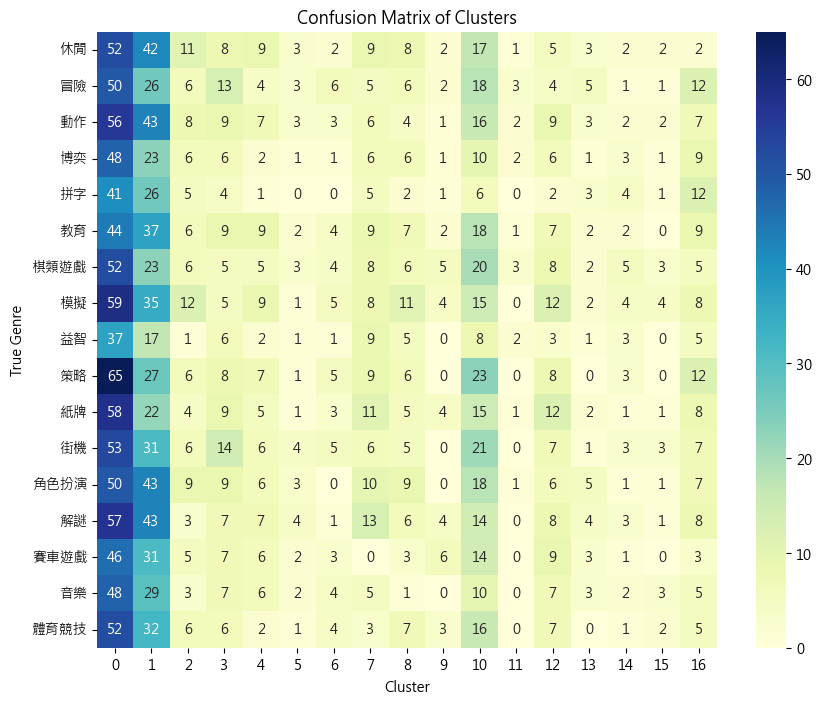

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

true_labels = [item.get('genre', i % 17) for i, item in enumerate(data)]
conf_matrix = pd.crosstab(pd.Series(true_labels, name='True Genre'), pd.Series(clusters, name='Cluster'))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix of Clusters")

plt.savefig("fun2.jpg")
plt.show()